In [1]:
!pip install pyvirtualdisplay

In [ ]:
!pip install tensorflow

In [3]:
!pip install gym==0.24.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.4/694.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.0-py3-none-any.whl size=790673 sha256=dfcc97d3cdd5f8d86ab2df616f3a4183d296b65b5631a479921edc0262cbe0dc
  Stored in directory: /root/.cache/pip/wheels/2f/a1/b1/5f4110c8943b36e6cdfcc0e5768481639fa042b3c8357e82cc
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [4]:
import time
from collections import deque, namedtuple
import gym
import numpy as np
import PIL.Image
import tensorflow as tf
from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [ ]:
!sudo apt-get install xvfb
# Set up a virtual display to render the Lunar Lander environment.
Display(visible=0, size=(840, 480)).start();

# Set the random seed for TensorFlow
tf.random.set_seed(42)

In [6]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
!sudo apt-get install -y python3-dev python3-pip
!sudo apt-get install swig
!pip install gym[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04).
python3-dev set to manually installed.
The following additional packages will be installed:
  python3-setuptools python3-wheel
Suggested packages:
  python-setuptools-doc
The following NEW packages will be installed:
  python3-pip python3-setuptools python3-wheel
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 1,677 kB of archives.
After this operation, 8,967 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-setuptools all 59.6.0-1.2ubuntu0.22.04.1 [339 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-wheel all 0.37.1-2ubuntu0.22.04.1 [32.0 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-pip all 22.0.2+dfsg-1ubuntu0.4 [1,305 kB]
Fetched 1,677 kB in 0s (5,283 kB/s)
debconf: unable

In [8]:
import gym
env = gym.make('LunarLander-v2')

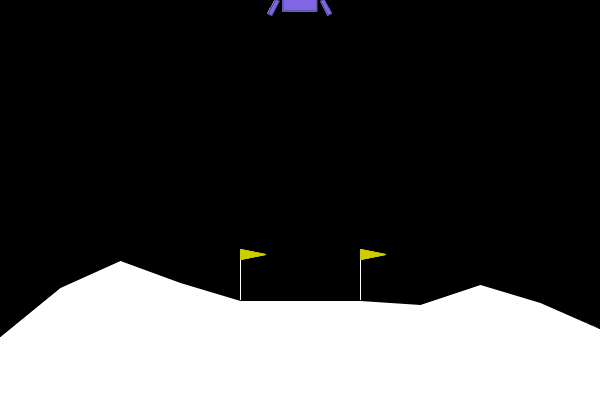

In [9]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [10]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [11]:
initial_state = env.reset()

In [12]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [13]:
# UNQ_C1
# GRADED CELL

# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ###
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ###
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ###
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ###
    ])

### START CODE HERE ###
optimizer = Adam(learning_rate=ALPHA)
### END CODE HERE ###

In [14]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [15]:
from tensorflow.keras.losses import MSE

In [16]:
# UNQ_C2
# GRADED FUNCTION: calculate_loss

def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calculates the loss.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ###
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###

    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Compute the loss
    ### START CODE HERE ###
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ###

    return loss

In [17]:
import base64
import random
from itertools import zip_longest

import imageio
import IPython
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import tensorflow as tf
from statsmodels.iolib.table import SimpleTable


SEED = 0              # seed for pseudo-random number generator
MINIBATCH_SIZE = 64   # mini-batch size
TAU = 1e-3            # soft update parameter
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy


random.seed(SEED)


def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)


def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False


def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)


def get_action(q_values, epsilon=0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(4))


def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)


def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):

    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]

    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')

    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'

    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()


def display_table(initial_state, action, next_state, reward, done):

    action_labels = ["Do nothing", "Fire right engine", "Fire main engine", "Fire left engine"]

    # Do not use column headers
    column_headers = None

    with np.printoptions(formatter={'float': '{:.3f}'.format}):
        table_info = [("Initial State:", [f"{initial_state}"]),
                      ("Action:", [f"{action_labels[action]}"]),
                      ("Next State:", [f"{next_state}"]),
                      ("Reward Received:", [f"{reward:.3f}"]),
                      ("Episode Terminated:", [f"{done}"])]

    # Generate table
    row_labels, data = zip_longest(*table_info)
    table = SimpleTable(data, column_headers, row_labels)

    return table


def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state = env.reset()
        frame = env.render(mode="rgb_array")
        video.append_data(frame)
        while not done:
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, _ = env.step(action)
            frame = env.render(mode="rgb_array")
            video.append_data(frame)

In [18]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.

    """

    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

In [19]:
# from utils.action_space import get_action
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)

        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)

        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -161.39
Episode 200 | Total point average of the last 100 episodes: -90.45
Episode 300 | Total point average of the last 100 episodes: -79.86
Episode 400 | Total point average of the last 100 episodes: 41.06
Episode 500 | Total point average of the last 100 episodes: 147.68
Episode 547 | Total point average of the last 100 episodes: 198.59

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Episode 548 | Total point average of the last 100 episodes: 201.49

Environment solved in 548 episodes!

Total Runtime: 1588.26 s (26.47 min)


In [25]:
def plot_history(history):
  """Plots the history of a Keras model.

  Args:
    history: The history of the Keras model.
  """

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'])
  plt.show()

In [27]:
def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):

    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]

    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')

    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'

    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()

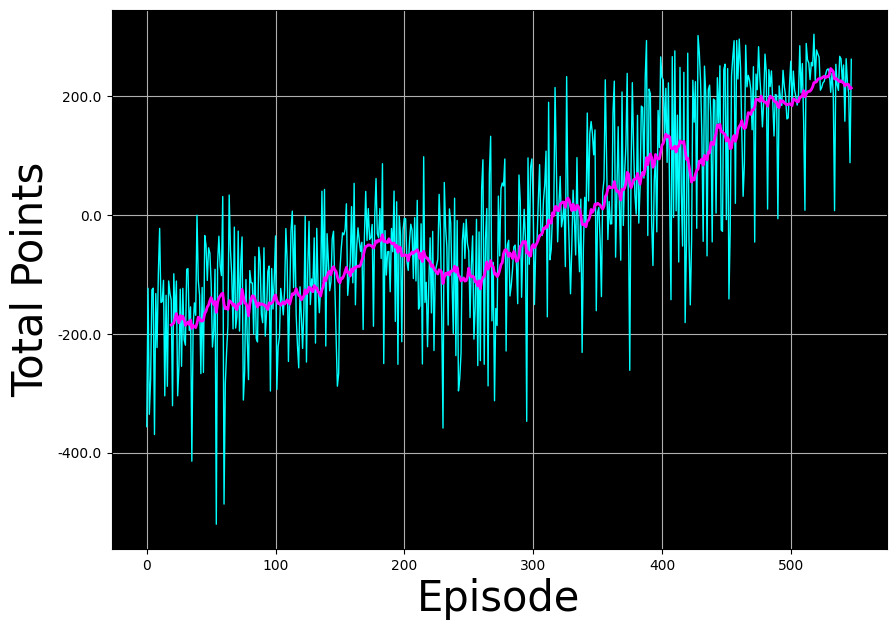

In [28]:
# Plot the point history
plot_history(total_point_history)

In [29]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [32]:

def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state = env.reset()
        frame = env.render(mode="rgb_array")
        video.append_data(frame)
        while not done:
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, _ = env.step(action)
            frame = env.render(mode="rgb_array")
            video.append_data(frame)

In [35]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
filename = "/content/drive/MyDrive/DriveApp/lunar_lander.mp4"

create_video(filename, env, q_network)
embed_mp4(filename)